In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kipet import KipetModel

### Parameter Estimation for a fed batch reaction
$A + B \rightarrow C$

Initial conditions in reactor: 
* Initial volume $V_0=1L$
* $c_{A0} = 2, c_{B0} = 0, c_{C0} = 0$ (mol/L).

A stream of $B$ with concentration $2 mol/L$ is charged into reactor at rate $0.1 L/min$ over 15min.

Data is simulated using reaction rate constant $k_1=0.1 min^{-1}$ with added noise

Governing equations are:
$$
\begin{eqnarray}
\frac{dc_A}{dt} &=& -\frac{c_Aqin_B}{V} - k_1c_Ac_B \\
\frac{dc_B}{dt} &=& \frac{(cin_B - c_B)qin_B}{V} - k_1c_Ac_B \\
\frac{dc_C}{dt} &=& -\frac{c_Cqin_B}{V} + k_1c_Ac_B \\
\frac{dV}{dt} &=& qin_B
\end{eqnarray}
$$

In [91]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('fed_batch_parest')

r1.add_parameter('k1', init = 0.1)

r1.add_component('A', state = 'concentration', init = 2.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

r1.add_component('V', state = 'state', init = 1.0)

r1.add_component('qin_B', state = 'trajectory')
r1.add_algebraic_variables(['qin_B'])

cin_B = 2

In [92]:
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.Z[t,'A'] * m.Y[t,'qin_B']/m.X[t,'V']-m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['B'] = (cin_B*m.Y[t,'qin_B'] - m.Z[t,'B'] * m.Y[t,'qin_B'])/m.X[t,'V']- m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['C'] = -m.Z[t,'C'] * m.Y[t,'qin_B']/m.X[t,'V'] + m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['V'] = m.Y[t, 'qin_B']
    return exprs

r1.add_equations(rule_odes)

In [93]:
qin_B_df = pd.DataFrame({'t':[0, 15, 16], 'qin_B': [0.1, 0.1, 0]}).set_index('t')
qin_B_df

,qin_B
t,
0,0.1
15,0.1
16,0.0


In [94]:
r1.add_dataset('Traj', category = 'trajectory', data = qin_B_df)
r1.datasets['Traj'].data

,qin_B
t,
0,0.1
15,0.1
16,0.0


In [95]:
#r1.fix_from_trajectory('Y', 'qin_B', 'Traj')

In [96]:
filename = '/home/paperspace/learn_kipet/my_data_sets/ABC_fedbatch.csv'
C_data = pd.read_csv(filename, index_col = 0)
C_data = C_data[['A', 'B', 'C']]
r1.add_dataset('C_data', category='concentration', data = C_data)
r1.datasets['C_data'].data

,A,B,C
0.000000,2.083423,0.000000,0.000000
0.006957,2.050325,0.001389,0.000001
0.125632,1.819311,0.024509,0.000306
0.556208,2.044662,0.099940,0.005443
1.495467,1.541831,0.228099,0.032088
3.140156,1.213143,0.376072,0.101885
5.778965,1.342635,0.514788,0.217732
10.109477,0.844124,0.649458,0.355846
15.010179,0.700708,0.753979,0.439982
16.201092,-0.063078,0.723019,0.470846


In [97]:
#r1.settings.collocation.nfe = 60

In [98]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')
r1.set_times(0, 60.0)

In [99]:
r1.settings.solver.linear_solver = 'ma27'
r1.run_opt()  

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
0 60.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.p

  62  1.3884477e-01 9.56e-02 8.00e-03  -5.7 1.45e+00  -2.9 1.00e+00 1.00e+00h  1
  63  1.3152018e-01 9.88e-01 4.04e-02  -5.7 1.61e+00  -3.4 1.00e+00 1.00e+00h  1
  64  1.2895485e-01 3.46e-02 2.72e-03  -5.7 1.22e+00  -3.0 1.00e+00 1.00e+00h  1
  65  1.2820922e-01 4.67e-02 1.94e-03  -5.7 6.04e-01  -3.4 1.00e+00 1.00e+00h  1
  66  1.2811046e-01 1.30e-02 4.15e-04  -5.7 2.81e-01  -3.9 1.00e+00 1.00e+00h  1
  67  1.2810735e-01 1.15e-04 5.03e-06  -5.7 6.45e-02  -4.4 1.00e+00 1.00e+00h  1
  68  1.2810712e-01 8.00e-05 2.47e-06  -5.7 4.49e-02  -4.9 1.00e+00 1.00e+00h  1
  69  1.2810675e-01 4.53e-04 1.24e-05  -5.7 1.13e-01  -5.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2810603e-01 2.38e-03 6.64e-05  -5.7 2.57e-01  -5.8 1.00e+00 1.00e+00h  1
  71  1.2810528e-01 5.77e-03 1.70e-04  -5.7 4.05e-01  -6.3 1.00e+00 1.00e+00h  1
  72  1.2810503e-01 3.46e-03 1.11e-04  -5.7 3.22e-01  -6.8 1.00e+00 1.00e+00h  1
  73  1.2810501e-01 3.26e-04


RESULTS
Z:
                   A         B         C
0.000000   2.000000  0.000000  0.000000
0.001079   2.057299 -0.052485 -0.002407
0.004487   2.083736 -0.057737 -0.012999
0.006957   2.041705 -0.007230 -0.017237
0.025358   2.072753 -0.010142 -0.031305
...             ...       ...       ...
58.519048 -0.018451 -0.219371  1.118911
58.907088  0.069609 -0.447751  1.189071
59.076545 -0.027086 -0.460379  1.243733
59.611960  0.004846 -0.366025  1.180590
60.000000 -0.165917 -0.300051  1.232984

[151 rows x 3 columns]

Cm:
                   A         B         C
0.000000   2.083423  0.000000  0.000000
0.006957   2.050325  0.001389  0.000001
0.125632   1.819311  0.024509  0.000306
0.556208   2.044662  0.099940  0.005443
1.495467   1.541831  0.228099  0.032088
3.140156   1.213143  0.376072  0.101885
5.778965   1.342635  0.514788  0.217732
10.109477  0.844124  0.649458  0.355846
15.010179  0.700708  0.753979  0.439982
16.201092 -0.063078  0.723019  0.470846
20.053501  0.283442  0.645382  0.5484

In [100]:
# Display the results
r1.results.show_parameters


The estimated parameters are:
k1 24.335804456352122


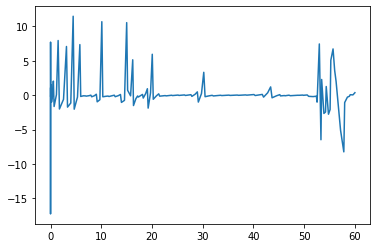

In [102]:
plt.plot(r1.results.Y.index, r1.results.Y['qin_B'])

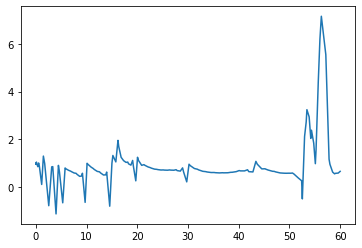

In [101]:
plt.plot(r1.results.X.index, r1.results.X['V'])